In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import os
import sys
import torch
import os
import sys
import shutil
import matplotlib.pyplot as plt
from math import pi

In [ ]:
from src.nn.DVPDESolver import DVPDESolver
from src.nn.CVPDESolver import CVPDESolver
from src.utils.logger import Logging
from src.utils.plotting import plot_results
from src.nn.pde import helmholtz_operator
from src.utils.plot_prediction import plt_prediction
from src.data.helmholtz_dataset import u, f

In [10]:
log_path = "./testing_checkpoints"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
torch.cuda.is_available()

True

## Generate Testing Dataset


In [11]:
# Test data
num_points = 10
A1 = 1
A2 = 4
LAMBDA = 1.0

dom_coords = torch.tensor([[-1.0, -1.0], [1.0, 1.0]], dtype=torch.float32).to(DEVICE)

t = (
    torch.linspace(dom_coords[0, 0], dom_coords[1, 0], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)

x = (
    torch.linspace(dom_coords[0, 1], dom_coords[1, 1], num_points)
    .to(DEVICE)
    .unsqueeze(1)
)
t, x = torch.meshgrid(t.squeeze(), x.squeeze())
X_star = torch.hstack((t.flatten().unsqueeze(1), x.flatten().unsqueeze(1))).to(DEVICE)

/home/khans/miniconda3/envs/QCPINN/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Load trained model


In [ ]:
model_dir = "models/2025-02-06_19-25-14-069398"  # circ_19

In [ ]:
data = X_star
solver = "DV"

model_path = os.path.join(model_dir, "model.pth")

if solver == "CV":
    state = CVPDESolver.load_state(model_path)
    model = CVPDESolver(state["args"], logger, data, DEVICE)

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])

elif solver == "Classical":
    from src.nn.ClassicalSolver import ClassicalSolver

    state = ClassicalSolver.load_state(model_path)
    if "hidden_network" in state:
        from src.nn.ClassicalSolver2 import ClassicalSolver2

        state = ClassicalSolver2.load_state(model_path)
        model = ClassicalSolver2(state["args"], logger, None, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.hidden.load_state_dict(state["hidden_network"])
        model.postprocessor.load_state_dict(state["postprocessor"])
    else:
        model = ClassicalSolver(state["args"], logger, None, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.postprocessor.load_state_dict(state["postprocessor"])

else:
    state = DVPDESolver.load_state(model_path)
    model = DVPDESolver(state["args"], logger, data, DEVICE)
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])


model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

model.logger.print(f"Totoal number of iterations : {len(state['loss_history'])}")
model.logger.print(f"The final loss : {state['loss_history'][-1]}")

model.loss_history = state["loss_history"]
model.model_path = logger.get_output_dir()


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")
shutil.copytree(
    model_dir,
    os.path.join(logger.get_output_dir(), model_dir.split("/")[-1]),
    dirs_exist_ok=True,
)

INFO:src.utils.logger:The settings used: {'batch_size': 64, 'epochs': 20000, 'lr': 0.0001, 'seed': 1, 'print_every': 50, 'log_path': './checkpoints/helmholtz', 'input_dim': 2, 'output_dim': 1, 'num_qubits': 5, 'hidden_dim': 50, 'num_quantum_layers': 1, 'classic_network': [2, 50, 1], 'q_ansatz': 'sim_circ_19', 'mode': 'hybrid', 'activation': 'tanh', 'shots': None, 'problem': 'helmholtz', 'solver': 'DV', 'device': 'cpu', 'method': 'None', 'cutoff_dim': 3, 'class': 'DVQuantumLayer', 'encoding': 'angle'}
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 50
INFO:src.utils.logger:log_path : ./checkpoints/helmholtz
INFO:src.utils.logger:input_dim : 2
INFO:src.utils.logger:output_dim : 1
INFO:src.utils.logger:num_qubits : 5
INFO:src.utils.logger:hidden_dim : 50
INFO:src.utils.logger:num_quantum_layers : 1
INFO:src.utils.logger:classic_network : [2, 50, 1]
INFO:src.utils

Model state loaded from models/2025-02-06_19-25-14-069398/model.pth


'./testing_checkpoints/2025-04-26_12-50-24-679142/2025-02-06_19-25-14-069398'

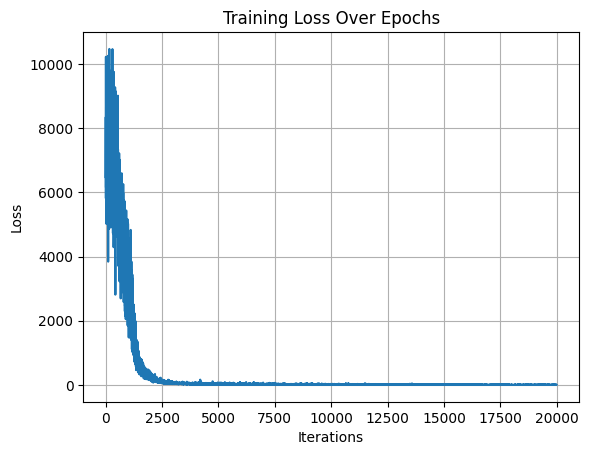

In [ ]:
n = len(model.loss_history)  ## 5000 # Number of last iterations to plot
plt.plot(range(len(model.loss_history[-n:])), model.loss_history[-n:])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

In [15]:
# Exact solution
u_star = u(X_star, A1, A2)
f_star = f(X_star, A1, A2, LAMBDA)


# Predictions
u_pred_star, f_pred_star = helmholtz_operator(model, X_star[:, 0:1], X_star[:, 1:2])

u_pred = u_pred_star.cpu().detach().numpy()
f_pred = f_pred_star.cpu().detach().numpy()
u_exact = u_star.cpu().detach().numpy()
f_exact = f_star.cpu().detach().numpy()
X = X_star.cpu().detach().numpy()

INFO:src.utils.logger:The circuit used in the study:


The circuit is saved in ./testing_checkpoints/2025-04-26_12-50-24-679142


In [ ]:
# Relative L2 error
error_u = np.linalg.norm(u_pred - u_exact, 2) / np.linalg.norm(u_exact, 2) * 100
error_f = np.linalg.norm(f_pred - f_exact, 2) / np.linalg.norm(f_exact, 2) * 100
logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))

INFO:src.utils.logger:Relative L2 error_u: 7.17e+00
INFO:src.utils.logger:Relative L2 error_f: 2.71e+00


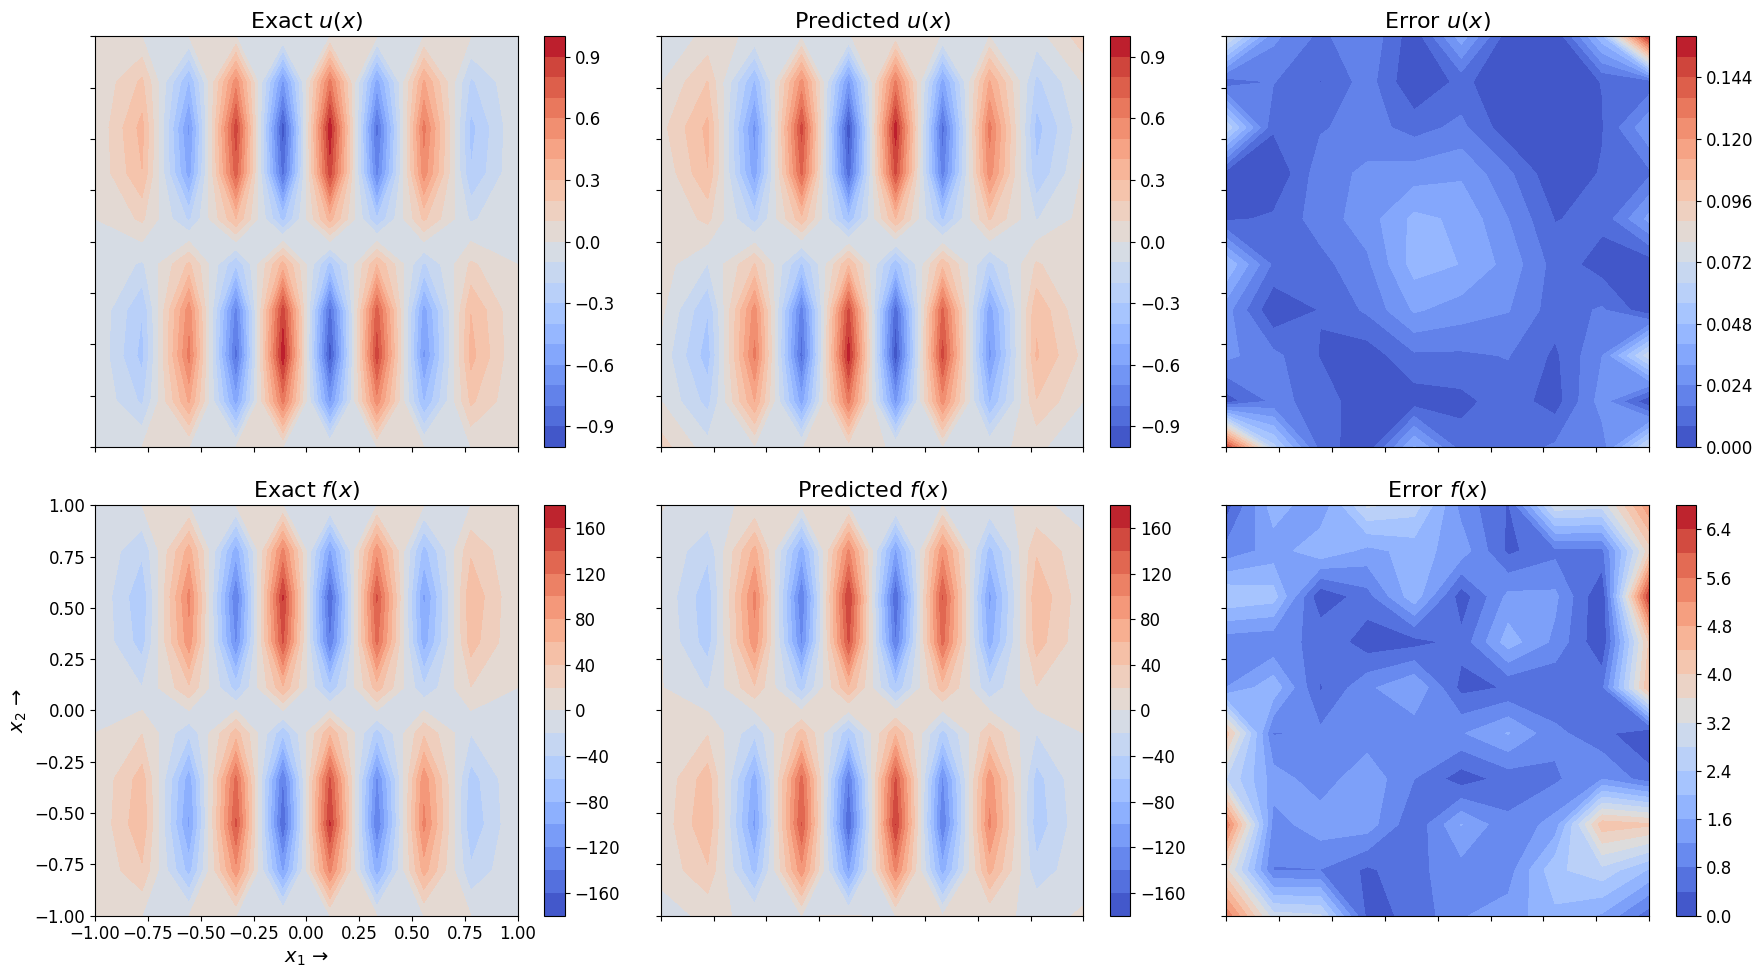

In [17]:
# Plot predictions
plt_prediction(
    logger,
    X,
    u_exact,
    u_pred,
    f_exact,
    f_pred,
)

### OR Simply call the python script

```bash
python -m src.contour_plots.klein_gordon_hybrid_plotting
```


In [ ]:
run -m src.contour_plots.helmholtz_hybrid_plotting

INFO:src.utils.logger:checkpoint path: self.log_path='testing_checkpoints/helmholtz/2025-04-26_12-56-05-716761'
INFO:src.utils.logger:Total number of iterations : 20000
INFO:src.utils.logger:The final loss : 6.134862422943115
INFO:src.utils.logger:Total number of parameters : 2751
INFO:src.utils.logger:Relative L2 error_u: 6.70e+00
INFO:src.utils.logger:Relative L2 error_f: 2.82e+00
INFO:src.utils.logger:Using DV Solver
INFO:src.utils.logger:Total number of iterations : 20000
INFO:src.utils.logger:The final loss : 3.630709648132324
INFO:src.utils.logger:Total number of parameters : 771
INFO:src.utils.logger:The circuit used in the study:


Model state loaded from ./models/2025-02-09_00-01-28-238904/model.pth
Model state loaded from ./models/2025-02-06_19-25-14-069398/model.pth
The circuit is saved in testing_checkpoints/helmholtz/2025-04-26_12-56-05-716761
